## Vehicle Detection and Tracking
### Udacity Self-Driving Car Term 1
### Project 4

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import random
#from heatMap import *
from sklearn.svm import LinearSVC
import sklearn.svm
from sklearn.preprocessing import StandardScaler
from scipy import ndimage
from skimage.feature import hog
#from vdfunctions import *
from sklearn.externals import joblib
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

from scipy.ndimage.measurements import label


### Feature Extraction Functions

In [2]:
# Code in this section was used in whole are slightly modified from code 
# provided in Lesson 20

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        color_transform = 'cv2.COLOR_BGR2'+ color_space
        n_color_transform = eval(color_transform)
        feature_image = cv2.cvtColor(img, n_color_transform)

    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #print('hog_features ',len(hog_features), type(hog_features) ) 
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows




# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=False): #True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        img = cv2.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            color_transform = 'cv2.COLOR_BGR2'+ color_space
            n_color_transform = eval(color_transform)
            feature_image = cv2.cvtColor(img, n_color_transform)
 
        else: feature_image = np.copy(img)           

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(shape, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
	
	# If x and/or y start/stop positions not defined, set to image size
	if x_start_stop[0] == None:
		x_start_stop[0] = 0
	if x_start_stop[1] == None:
		x_start_stop[1] = shape[1]
	if y_start_stop[0] == None:
		y_start_stop[0] = 0
	if y_start_stop[1] == None:
		y_start_stop[1] = shape[0]
	# Compute the span of the region to be searched    
	span_x = x_start_stop[1] - x_start_stop[0]
	span_y = y_start_stop[1] - y_start_stop[0]
	#shape= img.shape
	# Compute the number of pixels per step in x/y
	n_pix_per_step_x = np.int(xy_window[0]*xy_overlap[0])
	n_pix_per_step_y = np.int(xy_window[1]*xy_overlap[1])
	#print('n_pix_per_step_x ',n_pix_per_step_x,'n_pix_per_step_y ',n_pix_per_step_y, '\n')

	# Compute the number of windows in x/y
	n_windows_x = 1+ np.int((span_x - xy_window[0])/ n_pix_per_step_x)
	n_windows_y = 1+ np.int((span_y - xy_window[1])/ n_pix_per_step_y)
	#print('n_windows_x ',n_windows_x,'n_windows_y ',n_windows_y)
	# Initialize a list to append window positions to
	window_list = []
	# Loop through finding x and y window positions
	#     Note: you could vectorize this step, but in practice
	#     you'll be considering windows one by one with your
	#     classifier, so looping makes sense

	for num_y in np.arange(n_windows_y):
		window_start_y = y_start_stop[0] + (num_y*n_pix_per_step_y)
		window_stop_y = window_start_y + xy_window[1]
		#window_pos_y = (window_start_y,window_stop_y)
		for num_x in np.arange(n_windows_x):
			# Calculate each window position
			window_start_x = x_start_stop[0] + (num_x * n_pix_per_step_x)
			window_stop_x = window_start_x + xy_window[0]
			#window_pos_x = (window_start_x, window_stop_x)
			vertice1 = (window_start_x, window_start_y)
			vertice2 = (window_stop_x, window_stop_y)
			# Append window position to list
			window_list.append((vertice1, vertice2))
	# Return the list of windows
	return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6, randcolor = False):
    # Make a copy of the image
    imcopy = np.copy(img)
    
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if randcolor == True:
            c1 = random.randint(0,255)
            c2 = random.randint(0,255)
            c3 = random.randint(0,255)
            color = (c1,c2,c3)
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def find_dist(temp_cent, curr_cent):
	return	np.sqrt((temp_cent[0]-curr_cent[0])**2 + (temp_cent[1]-curr_cent[1])**2)

### Heatmap Functions

In [3]:

#All code below taken from Lesson 20, Sect 37 

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy import ndimage

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    label_windows=[]
    set_pts=[]
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        label_windows.append(bbox)
        set_pts.append([set(nonzeroy), set(nonzerox)])
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    label_windows = np.asarray(label_windows)
    #print('label_windows.shape: ', label_windows.shape)
    # Return the image
    return [img, label_windows, set_pts]



### Feature Parameters

In [4]:
### Parameters for feature extraction
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 4 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32   # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
#y_start_stop = [shape[0]//3, shape[0]] # Min and max in y to search in slide_window()


### Classifier Training

In [ ]:
model_dir = './model'
train_model_name = model_dir + 'svm_train_'+str(color_space)+'_'+ hog_channel+'.pkl'+'_0622_rbf_16c50'
scaler_model_name = model_dir + 'X_scaler_'+str(color_space)+'_'+ hog_channel+'.pkl'+'_0622_rbf_16c50'

    
# Read in list of image path names and sort by car or not car depending on folder path
# ** code adapted from Lesson 20, section 34
CarsList1 = './vehicles/GTI_Far'
CarsList2 = './vehicles/GTI_Left'
CarsList3 = './vehicles/GTI_MiddleClose'
CarsList4 = './vehicles/GTI_Right'
CarsList5 = './vehicles/KITTI_extracted'
NotCarsList1 = 'non-vehicles/Extras'
NotCarsList2 = 'non-vehicles/GTI'
NotCarsList3 = './added_noncar'
CarsListUD = './vehicles_UD'
CarsListUD2 = './new_input/cars'
NotCarsListUD = './new_input/notcars'
List_of_Cars = [CarsList1,CarsList2,CarsList3,CarsList4,CarsList5]
List_of_Cars_UD = [CarsListUD, CarsListUD2]
List_of_NotCars = [NotCarsList1,NotCarsList2]
List_of_NotCars_Add =  [NotCarsList3, NotCarsListUD]

# sorts path file name of cars list and notcars list
cars = []
notcars = []

for folder in List_of_Cars:
    #print(folder)
    images = glob.glob(folder + '/*.png')
    #images = glob.glob(folder + '/*.jpg')
    for image in images:
        cars.append(image)

# Add UD cars to list
for folder in List_of_Cars_UD:
    images = glob.glob(folder + '/*.jpg')
    for image in images:
        cars.append(image)

for folder in List_of_NotCars:
    images = glob.glob(folder + '/*.png')
    for image in images:
        notcars.append(image)

# Add UD cars to list
for folder in List_of_NotCars_Add:
    images = glob.glob(folder + '/*.jpg')
    for image in images:
        notcars.append(image)
   
print('cars    ', len(cars))
print('notcars ', len(notcars))
# compare size of each 'class' and trim the longest of the two to have equal sizes
sz_cars = len(cars)
sz_notcars = len(notcars)

if (sz_cars > sz_notcars):
	cars= shuffle(cars, n_samples = sz_notcars)
if (sz_cars < sz_notcars):
	notcars = shuffle(notcars, n_samples = sz_cars)
	print('cars    ', len(cars))
	print('notcars ', len(notcars))

# find features of cars and notcars
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

#print('len(X) ',X.shape, 'len(y) ',y.shape)

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)
   
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)


print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))


# Uncomment below to train a linear SVC 
#svc = LinearSVC()
# Comment line below to not train non-linear SVM
svc = svm.SVC(kernel='rbf', C=0.5)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

# Save model to disk
joblib.dump(X_scaler, scaler_model_name)	
joblib.dump(svc, train_model_name)
print('Data: X_scaler, svc  saved to disk')


### Model Loading

In [6]:
model_dir = './model/'
train_model_name = model_dir + 'svm_train_'+str(color_space)+'_'+ hog_channel+'.pkl_0618'
scaler_model_name = model_dir + 'X_scaler_'+str(color_space)+'_'+ hog_channel+'.pkl_0618'

# Linear SVM Model
svc = joblib.load('./model/svm_train_YCrCb_ALL.pkl_0618_32')
X_scaler = joblib.load('./model/X_scaler_YCrCb_ALL.pkl_0618_32')

# Nonlinear SVM
#svc = joblib.load('./model/svm_train_YCrCb_ALL.pkl_0622_rbf_16c')
#X_scaler = joblib.load('./model/X_scaler_YCrCb_ALL.pkl_0622_rbf_16')

print('Done Loading Model Data.')


Done Loading Model Data.


## Single Image Classification

elapsed time:  4.362029552459717


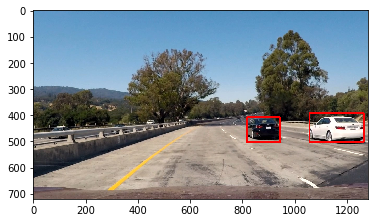

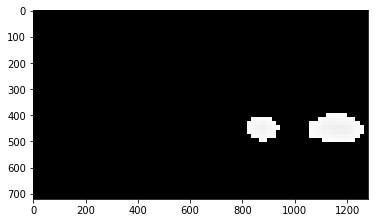

In [9]:
shape = (720, 1280, 3)
x_begin = 0 
x_end = shape[1]
y_start_stop = [shape[0]//2, shape[0]-60] # Min and max in y to search in slide_window()
xy_size = 64
overlap = 0.25
n_pix_per_step_x = np.int(xy_size*overlap)
n_pix_per_step_y = np.int(xy_size*overlap)
n_windows_x = 1+ np.int(( (x_end-x_begin) - xy_size)/ n_pix_per_step_x)
n_windows_y = 1+ np.int(( (y_start_stop[1]-y_start_stop[0]) - xy_size)/ n_pix_per_step_y)

windows = slide_window(shape, x_start_stop=[None, None], y_start_stop=y_start_stop, xy_window=(xy_size,xy_size), xy_overlap=(overlap, overlap))
#windows = variable_slide_window(shape, x_start_stop=[None, None], y_start_stop=y_start_stop, xy_window=(xy_size,xy_size), xy_overlap=(overlap, overlap))

# Create Circular Buffer, use only if testing multiple sequential images from video
heat_idx = 0
heat_list_size = 5
heat_list = np.ndarray([heat_list_size, shape[0], shape[1]])
heat_thresh = 40
frame_count = 0; 

file_dir = './test_images/test11.jpg'
#file_dir = 'test_images/video_images/'

for i in np.arange(1): #heat_list_size):
    #img = file_dir+'vid' + str(i)+'.jpg'
    #img = 'test_images/video_images/vid28.jpg'
    img = file_dir
    frame = cv2.imread(img)
    heat = np.zeros_like(frame).astype(np.float)

    # pass hog_features as arg to search_windows()

    t0 = time.time()
    hot_windows = search_windows(frame, windows, svc, X_scaler, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat,hog_feat=hog_feat)

    # Create heatmap by thresholding heat image 
    heat = add_heat(heat, hot_windows)
    heat = apply_threshold(heat, 3)
    heatmap  = np.clip(heat, 0,255)
    '''
    heat_list[heat_idx]= heat[:,:,0]
    heat_idx +=1
    if(heat_idx >heat_list_size-1):
        heat_idx = 0
    
    print(i)
#end for loop
# heatmap thresholding idea from post by andres_daiminger at 
# https://discussions.udacity.com/t/is-using-hog-subsample-method-required/235326/6

# Only use if testing multiple sequential images from video
    heat_sum = np.sum(heat_list, axis = 0)
    heat = apply_threshold(heat_sum, heat_thresh)
    heatmap = np.clip(heat, 0,255)
    '''
    labels= label(heatmap)
    #box = cv2.groupRectangles(labels, 2)
    window_img, window_pts, set_pts = draw_labeled_bboxes(np.copy(frame), labels)
    #cen=np.zeros((2,2))
#    cv2.imshow('', window_img)
#    cv2.waitKey(15)

    #cv2.imwrite('./output_images/test'+str(i)+'.jpg', window_img)
    #cv2.imwrite('./output_images/single_image.jpg', window_img)

t1 = time.time()

print('elapsed time: ', t1-t0)

window_img = cv2.cvtColor(window_img, cv2.COLOR_BGR2RGB)
plt.figure()
#plt.subplot(1,2,1)
plt.imshow(window_img)
#plt.subplot(1,2,2)
plt.figure()
plt.imshow(heatmap)
plt.imsave('./output_images/single_test_img.png', window_img)
#plt.show()


### Video Processing

In [ ]:
# RUN VEHICLE DETECTION ON TEST VIDEO

TEST= False
Add_Frame_Num = True

if (TEST):
    videofile1 = 'test_video.mp4'
    video_out = 'output_images/test1.mp4'

else:    
    videofile1 = './project_video.mp4'
    video_out = './output_images/project_video_Linear.mp4'
    #video_out = 'output_images/project_video_Detect_rbfc50.mp4'

font = cv2.FONT_HERSHEY_SIMPLEX    

curr_vehicles = []
past_vehicles=[]
temp_vehicles =[]

shape = (720, 1280, 3)

# Create circular buffer for heat images
heat_idx = 0
heat_list_size = 10
heat_list = np.ndarray([heat_list_size, shape[0], shape[1]])
heat_thresh = 35 #75

frame_count = 0
cap = cv2.VideoCapture(videofile1)
print('Opening Video')
if cap.isOpened() == 0:
	print('Video Not Opened')
else:
	fps = cap.get(5)
	ysize = cap.get(4)
	xsize = cap.get(3)
	print('fps ', fps, 'ysize ', ysize, 'xsize ', xsize)    
	print('Video Opened')


codex = cv2.VideoWriter_fourcc('M','J','P','G')
vout = cv2.VideoWriter(video_out, codex, fps,(int(xsize),int(ysize)) )


x_begin = 0, 
x_end = shape[1]
y_start_stop = [shape[0]//2, shape[0]-60] # Min and max in y to search in slide_window()
xy_size = 64
overlap = 0.25

windows = slide_window(shape, x_start_stop=[None, None], y_start_stop=y_start_stop, xy_window=(xy_size,xy_size), xy_overlap=(overlap,overlap))
'''
while(frame_count < 490): #900):
    cap.read()
    frame_count +=1

while(frame_count < 527): #1025):
'''

while(1):
	ret, frame = cap.read()
	if(ret == 0): break
	frame_count += 1
	print(frame_count)

	draw_image = np.copy(frame)
	heat = np.zeros_like(frame).astype(np.float)

	hot_windows = search_windows(frame, windows, svc, X_scaler, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat,hog_feat=hog_feat)                       


	heat = add_heat(heat, hot_windows)
	#heat = apply_threshold(heat,3)
    
	
	heat_list[heat_idx]= heat[:,:,0]
	heat_idx +=1
	if(heat_idx >heat_list_size-1):
		heat_idx = 0
	#end for loop

	# multiple heatmap thresholding idea from post by andres_daiminger at 
	# https://discussions.udacity.com/t/is-using-hog-subsample-method-required/235326/6
	heat_sum = np.sum(heat_list, axis = 0)
	heat = apply_threshold(heat_sum, heat_thresh)
    
	   
	heatmap = np.clip(heat, 0,255)
	labels= label(heatmap)

	window_img, window_pts, set_pts = draw_labeled_bboxes(np.copy(frame), labels)
	
	minimap = cv2.resize(heatmap, (213,120), interpolation=cv2.INTER_LINEAR)
	minimap = minimap * 8
	for chan in np.arange(window_img.shape[2]):
		window_img[0:120,0:213,chan] = minimap
	    
	if (Add_Frame_Num):
		frame= cv2.putText(window_img,str(frame_count),(10,600), font, 1,(255,255,255),2,cv2.LINE_AA)

	vout.write(window_img)
#	cv2.imshow('', window_img)
#	if cv2.waitKey(int(fps)) & 0xFF == ord('q'):	
#		break
        
cap.release()
vout.release()        
print('Done')